In [1]:
!pip install GEOparse
!pip install anndata
!pip install numcodecs

  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
Using cached packaging-25.0-py3-none-any.whl (66 kB)
   ---------------------------------------- 0.0/801.4 kB ? eta -:--:--
   --------------------------------------- 801.4/801.4 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.


In [3]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy import stats
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt


from prob.progression import Progression_Inference
from prob.ode_bayesian_lasso import ODE_BayesianLasso

## Synthetic Data Validation for PROB

In [19]:
np.random.seed(42)
n_genes, n_samples = 20, 50
t = np.linspace(0, 1, n_samples)
stages = np.clip(np.digitize(t, np.linspace(0, 1, 5)) - 1, 1, 4)
expr = np.zeros((n_genes, n_samples))
for g in range(n_genes):
    if g < 8:
        expr[g, :] = t * (1 + np.random.randn(n_samples)*0.2) + np.random.randn(n_samples)*0.1
    elif g < 16:
        expr[g, :] = (1-t) * (1 + np.random.randn(n_samples)*0.2) + np.random.randn(n_samples)*0.1
    else:
        expr[g, :] = np.random.randn(n_samples) + 1
expr = np.maximum(expr, 0.1)
X_stage = np.vstack([expr, stages])
print(f'Test data: {X_stage.shape}')

Data_ordered, PPD, TimeSampled = Progression_Inference(X_stage)
Para_Post_pdf, S, AM = ODE_BayesianLasso(Data_ordered, TimeSampled)

assert Data_ordered.shape == (n_genes, n_samples)
assert S.shape == (n_genes, n_genes)
assert AM.shape == (n_genes, n_genes)
print(f'✓ ALL TESTS PASSED')
print(f'Step 1 - Progression correlation: {np.corrcoef(t, PPD)[0,1]:.4f}')
print(f'Step 2 - Network: {np.sum(AM!=0)} edges, density={np.sum(AM!=0)/(n_genes*(n_genes-1)):.4f}')

Test data: (21, 50)
Step 2: GRN Inference
✓ Step 2 complete: 6 edges
✓ ALL TESTS PASSED
Step 1 - Progression correlation: 0.9506
Step 2 - Network: 6 edges, density=0.0158


## Reproducing PROB paper figures

In [24]:
import scipy.io as sio

# Load real data from PROB paper
mat = sio.loadmat('ExampleData.mat')
X_stage_real = mat['X_stage']
PPD_real = mat['PPD'].flatten()
Data_smooth_real = mat['Data_smooth']
AM_real = mat['AM']
S_real = mat['S']
TimeSampled_real = mat['TimeSampled'].flatten()

print(f'Loaded real data from PROB paper:')
print(f'  X_stage: {X_stage_real.shape} (genes × samples)')
print(f'  PPD: {PPD_real.shape} (progression distances)')
print(f'  Data_smooth: {Data_smooth_real.shape} (ordered data)')
print(f'  AM: {AM_real.shape} (adjacency matrix)')
print(f'  S: {S_real.shape} (presence probabilities)')

Loaded real data from PROB paper:
  X_stage: (8, 100) (genes × samples)
  PPD: (100,) (progression distances)
  Data_smooth: (6, 90) (ordered data)
  AM: (6, 6) (adjacency matrix)
  S: (6, 6) (presence probabilities)


C:\Users\belda\anaconda3\Lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


C:\Users\belda\AppData\Local\Temp\ipykernel_3640\4151805792.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


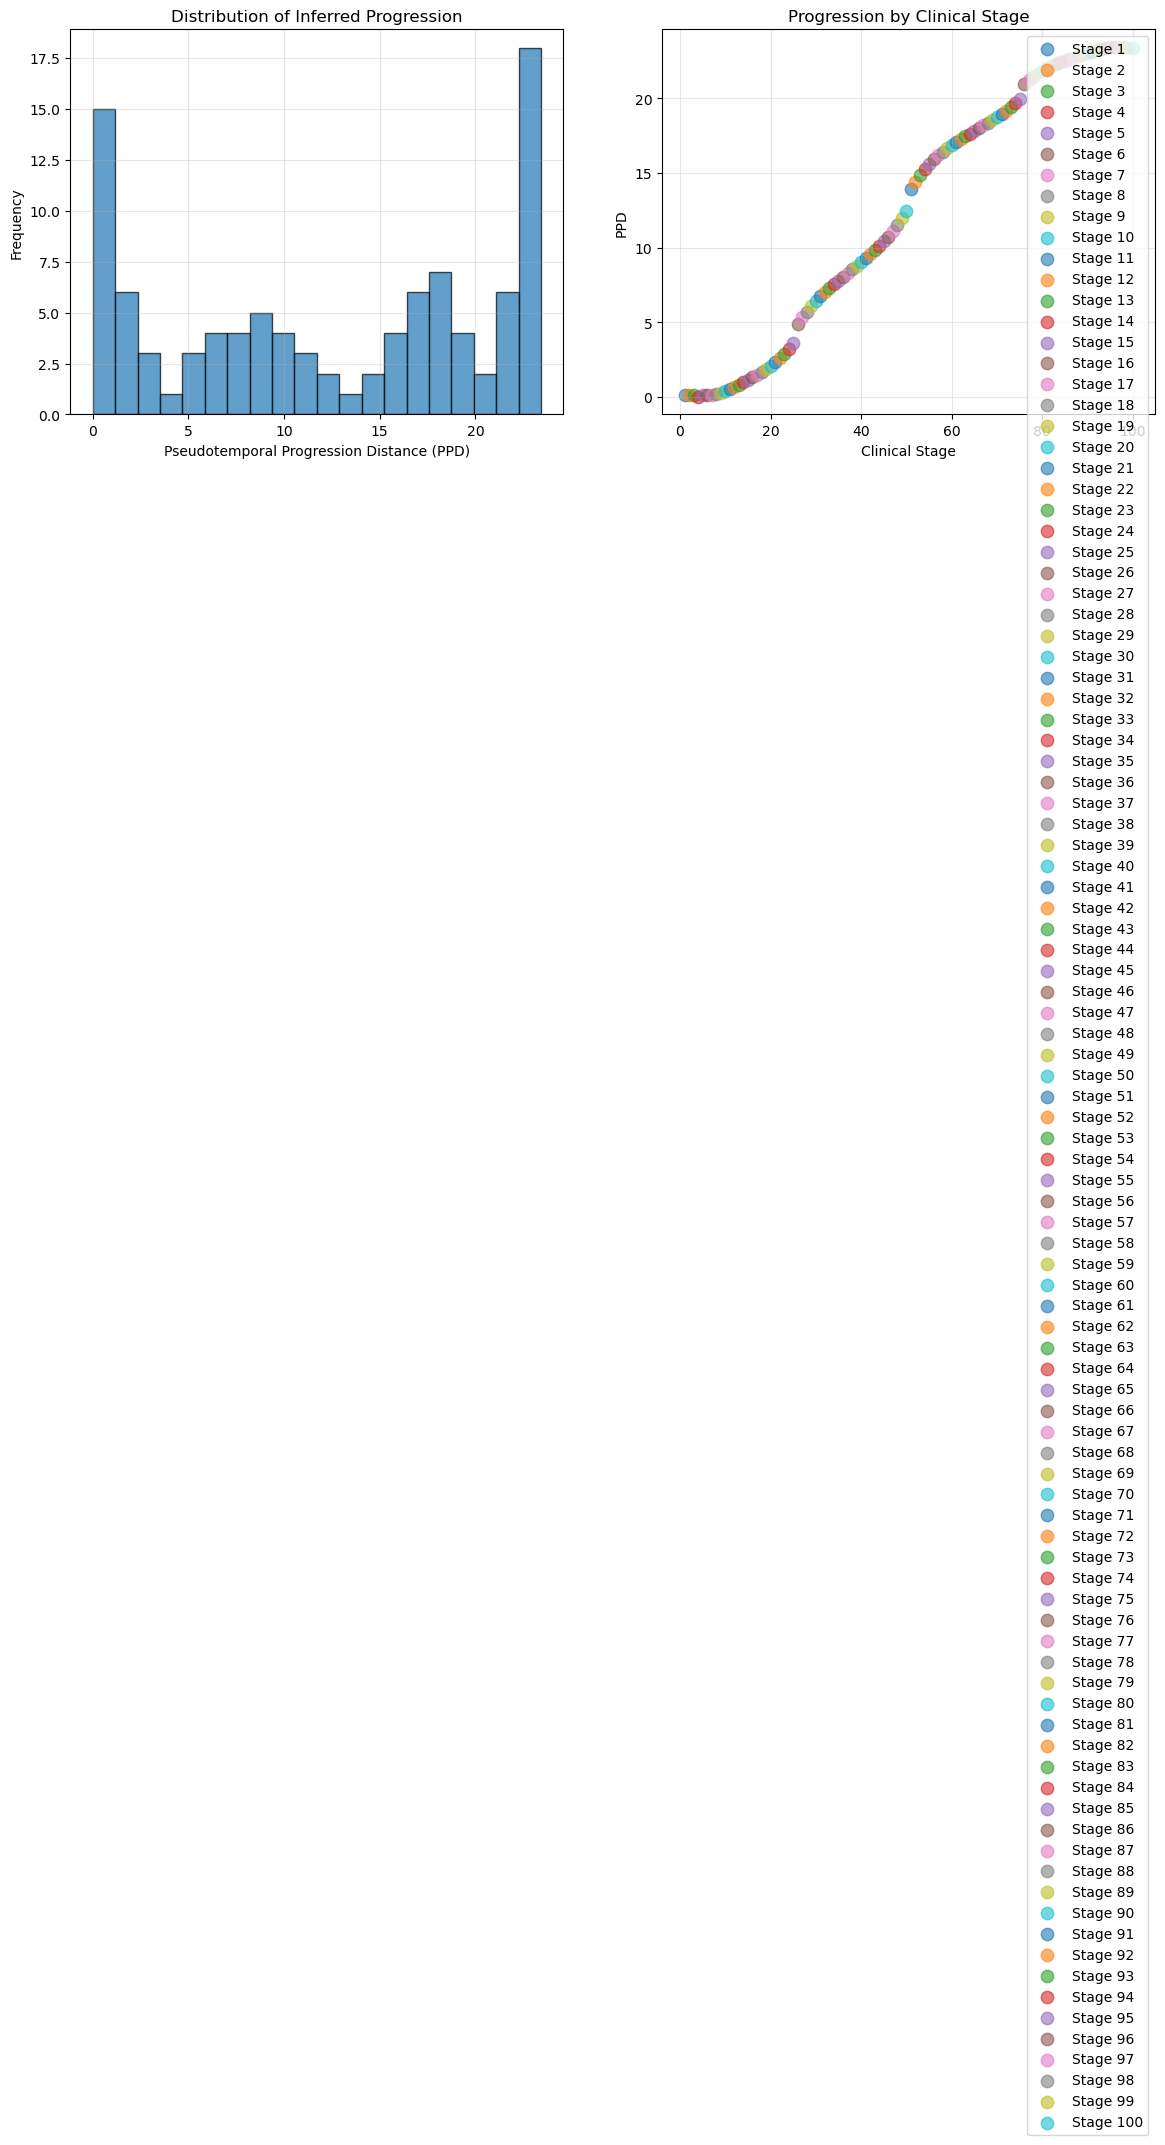

In [26]:
# Pseudotemporal Progression Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PPD histogram
ax = axes[0]
ax.hist(PPD_real, bins=20, alpha=0.7, edgecolor='black')
ax.set_xlabel('Pseudotemporal Progression Distance (PPD)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Inferred Progression')
ax.grid(True, alpha=0.3)

# Stage distribution
ax = axes[1]
stages = X_stage_real[-1, :].astype(int)
for stage in np.unique(stages):
    mask = stages == stage
    ax.scatter([stage]*np.sum(mask), PPD_real[mask], label=f'Stage {stage}', alpha=0.6, s=80)
ax.set_xlabel('Clinical Stage')
ax.set_ylabel('PPD')
ax.set_title('Progression by Clinical Stage')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

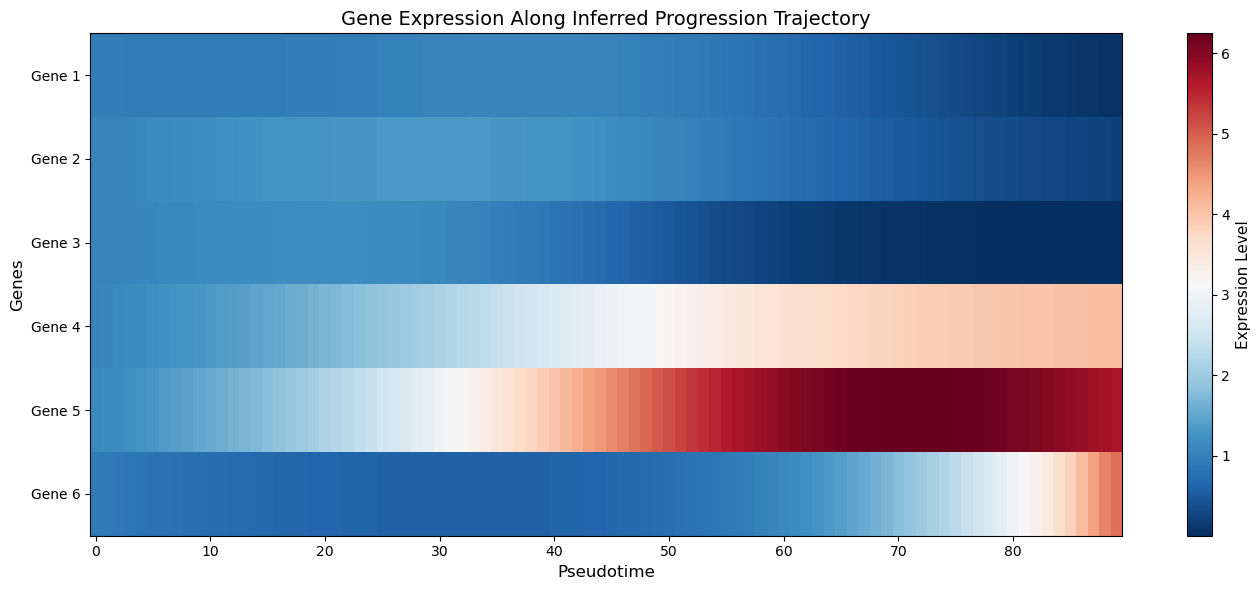

In [27]:
# Gene Expression Heatmap Along Progression
fig, ax = plt.subplots(figsize=(14, 6))

# Plot heatmap of smoothed data
im = ax.imshow(Data_smooth_real, aspect='auto', cmap='RdBu_r')
ax.set_xlabel('Pseudotime', fontsize=12)
ax.set_ylabel('Genes', fontsize=12)
ax.set_title('Gene Expression Along Inferred Progression Trajectory', fontsize=14)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Expression Level', fontsize=11)

ax.set_yticks(np.arange(Data_smooth_real.shape[0]))
ax.set_yticklabels([f'Gene {i+1}' for i in range(Data_smooth_real.shape[0])])

plt.tight_layout()
plt.show()


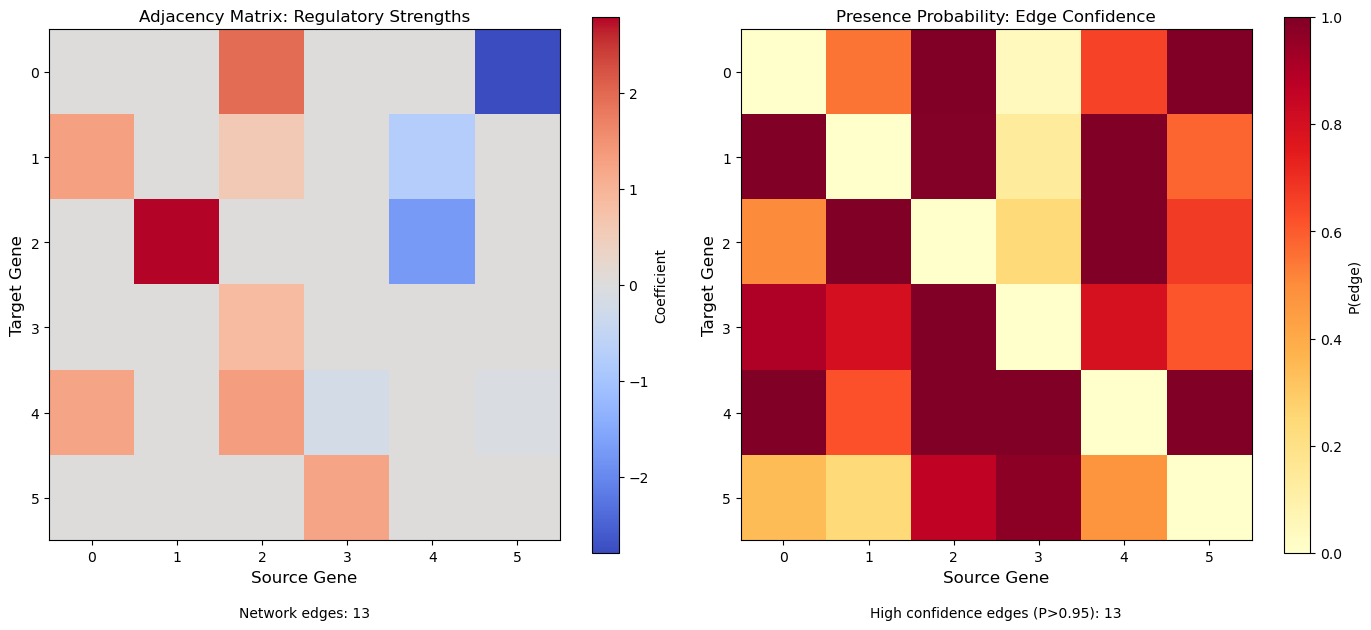

In [28]:
# Inferred Gene Regulatory Network
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Adjacency matrix (AM)
ax = axes[0]
vmax = np.max(np.abs(AM_real))
im1 = ax.imshow(AM_real, cmap='coolwarm', vmin=-vmax, vmax=vmax)
ax.set_xlabel('Source Gene', fontsize=12)
ax.set_ylabel('Target Gene', fontsize=12)
ax.set_title('Adjacency Matrix: Regulatory Strengths', fontsize=12)
cbar1 = plt.colorbar(im1, ax=ax)
cbar1.set_label('Coefficient', fontsize=10)
n_edges = np.sum(AM_real != 0)
ax.text(0.5, -0.15, f'Network edges: {n_edges}', transform=ax.transAxes, ha='center')

# Presence probability (S)
ax = axes[1]
im2 = ax.imshow(S_real, cmap='YlOrRd', vmin=0, vmax=1)
ax.set_xlabel('Source Gene', fontsize=12)
ax.set_ylabel('Target Gene', fontsize=12)
ax.set_title('Presence Probability: Edge Confidence', fontsize=12)
cbar2 = plt.colorbar(im2, ax=ax)
cbar2.set_label('P(edge)', fontsize=10)
high_conf = np.sum(S_real > 0.95)
ax.text(0.5, -0.15, f'High confidence edges (P>0.95): {high_conf}', transform=ax.transAxes, ha='center')

plt.tight_layout()
plt.show()

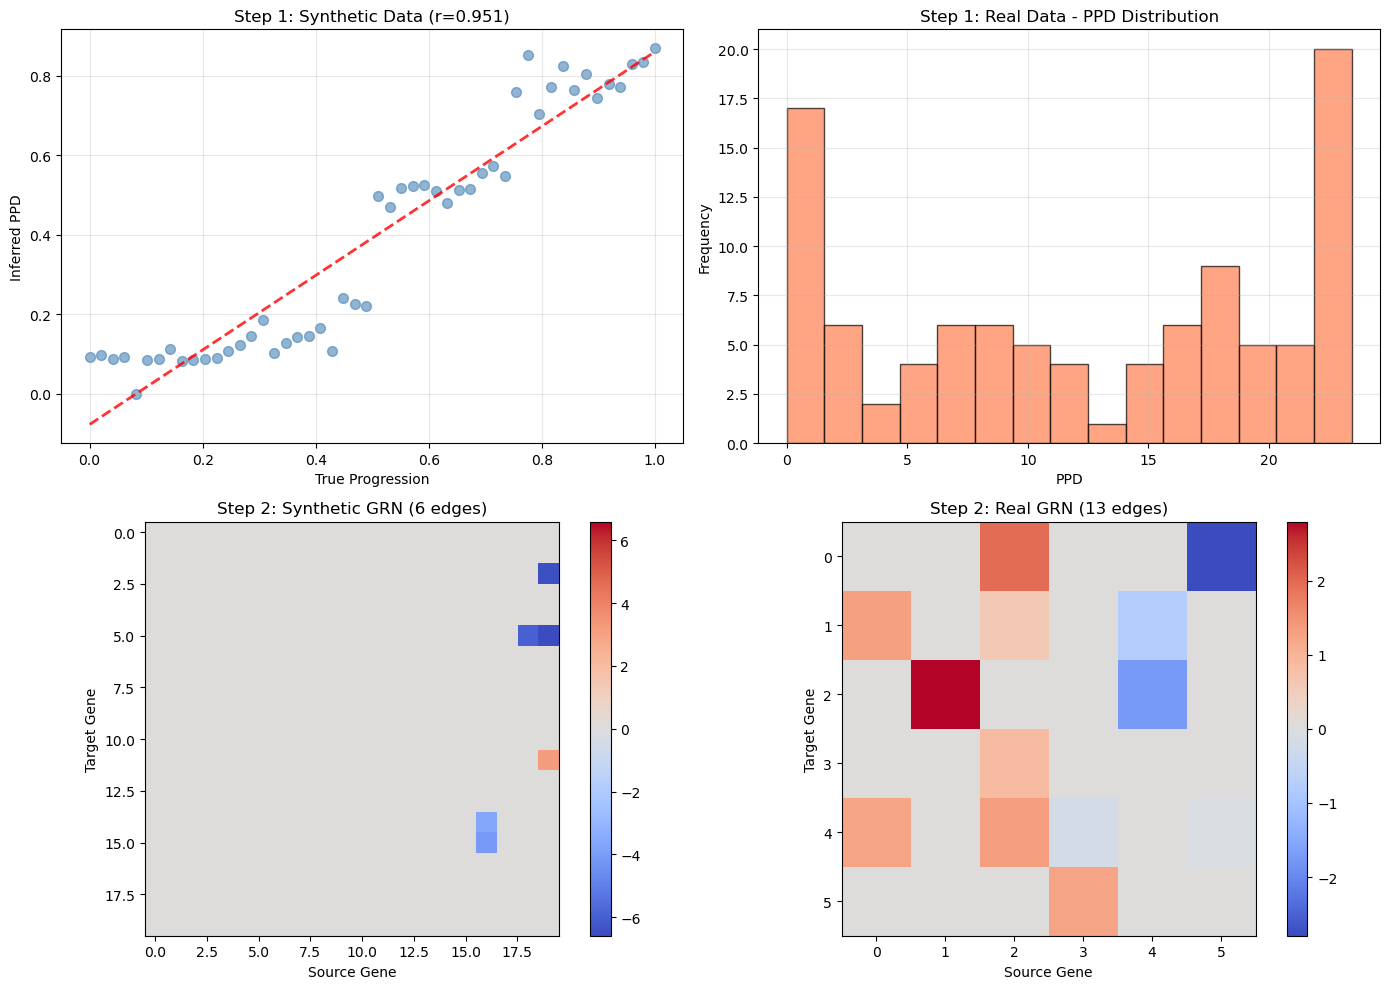

In [32]:
# Comparison - Synthetic vs Real Data Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Synthetic data (Step 1)
ax = axes[0, 0]
ax.scatter(t, PPD, alpha=0.6, s=50, color='steelblue', label='Synthetic Data')
z = np.polyfit(t, PPD, 1)
p = np.poly1d(z)
ax.plot(t, p(t), 'r--', alpha=0.8, linewidth=2)
r_syn = np.corrcoef(t, PPD)[0, 1]
ax.set_xlabel('True Progression')
ax.set_ylabel('Inferred PPD')
ax.set_title(f'Step 1: Synthetic Data (r={r_syn:.3f})')
ax.grid(True, alpha=0.3)

# Real data - PPD range
ax = axes[0, 1]
ax.hist(PPD_real, bins=15, alpha=0.7, edgecolor='black', color='coral')
ax.set_xlabel('PPD')
ax.set_ylabel('Frequency')
ax.set_title('Step 1: Real Data - PPD Distribution')
ax.grid(True, alpha=0.3)

# Synthetic network
ax = axes[1, 0]
vmax_syn = np.max(np.abs(AM))
im = ax.imshow(AM, cmap='coolwarm', vmin=-vmax_syn, vmax=vmax_syn)
ax.set_title(f'Step 2: Synthetic GRN ({np.sum(AM!=0)} edges)')
ax.set_xlabel('Source Gene')
ax.set_ylabel('Target Gene')
plt.colorbar(im, ax=ax)

# Real network
ax = axes[1, 1]
vmax_real = np.max(np.abs(AM_real))
im = ax.imshow(AM_real, cmap='coolwarm', vmin=-vmax_real, vmax=vmax_real)
ax.set_title(f'Step 2: Real GRN ({np.sum(AM_real!=0)} edges)')
ax.set_xlabel('Source Gene')
ax.set_ylabel('Target Gene')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()